<a href="https://colab.research.google.com/github/willystw/fastai-learning/blob/fraud-detection/fraud-detection/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook waterfallcharts treeinterpreter dtreeviz
!pip install --upgrade --force-reinstall --no-deps kaggle
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.3 MB/s 
     |████████████████████████████████| 60 kB 7.8 MB/s 
     |████████████████████████████████| 46 kB 3.9 MB/s 
     |████████████████████████████████| 186 kB 48.2 MB/s 
     |████████████████████████████████| 1.2 MB 30.5 MB/s 
     |████████████████████████████████| 56 kB 3.4 MB/s 
     |████████████████████████████████| 51 kB 299 kB/s 
     |████████████████████████████████| 58 kB 3.3 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=8214a2126097aa15f7520d3b00405fd2de94ceeeebf2004e8ae27717f458f1e0
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
Mounted at /content/gdrive


Import kaggle.json before executing the next step

In [4]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [5]:
#hide
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [6]:
path = URLs.path('fraud_detection')
path

Path('/root/.fastai/archive/fraud_detection')

In [7]:
#hide
Path.BASE_PATH = path

In [9]:
if not path.exists():
    path.mkdir(parents=true)
    api.dataset_download_cli('volodymyrgavrysh/fraud-detection-bank-dataset-20k-records-binary', path=path, unzip=True)

path.ls(file_type='text')


(#1) [Path('fraud_detection_bank_dataset.csv')]

In [10]:
df = pd.read_csv(path/'fraud_detection_bank_dataset.csv', low_memory=False)

In [29]:
df.columns

Index(['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'col_8', 'col_9',
       ...
       'col_103', 'col_104', 'col_105', 'col_106', 'col_107', 'col_108',
       'col_109', 'col_110', 'col_111', 'targets'],
      dtype='object', length=113)

In [96]:
#Remove Unnamed column
df.drop('Unnamed: 0', axis=1, inplace=True)

KeyError: ignored

In [31]:
dep_var='targets'

In [32]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

cont,cat

(['col_0',
  'col_1',
  'col_2',
  'col_3',
  'col_4',
  'col_5',
  'col_6',
  'col_7',
  'col_13',
  'col_14',
  'col_15',
  'col_16',
  'col_17',
  'col_22',
  'col_23',
  'col_24',
  'col_25',
  'col_26',
  'col_27',
  'col_28',
  'col_29',
  'col_30',
  'col_31',
  'col_32',
  'col_33',
  'col_34',
  'col_36',
  'col_37',
  'col_38',
  'col_39',
  'col_40',
  'col_41',
  'col_42',
  'col_43',
  'col_44',
  'col_45',
  'col_46',
  'col_47',
  'col_48',
  'col_49',
  'col_50',
  'col_54',
  'col_55',
  'col_56',
  'col_57',
  'col_58',
  'col_59',
  'col_60',
  'col_61',
  'col_62',
  'col_63',
  'col_64',
  'col_65',
  'col_66',
  'col_67',
  'col_68',
  'col_69',
  'col_72',
  'col_73',
  'col_74',
  'col_75',
  'col_76',
  'col_77',
  'col_78',
  'col_79',
  'col_80',
  'col_81',
  'col_82',
  'col_83',
  'col_84',
  'col_85',
  'col_86',
  'col_87',
  'col_88',
  'col_89',
  'col_90',
  'col_91',
  'col_92',
  'col_93',
  'col_94',
  'col_95',
  'col_96',
  'col_97',
  'col_98',


In [33]:
procs = [Categorify, FillMissing]

In [34]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=RandomSplitter(valid_pct=0.2)(range_of(df)))

In [35]:
len(to.train),len(to.valid)

(16375, 4093)

In [36]:
to.show(5)

,col_8,col_9,col_10,col_11,col_12,col_18,col_19,col_20,col_21,col_35,col_51,col_52,col_53,col_70,col_71,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_13,col_14,col_15,col_16,col_17,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_54,col_55,col_56,col_57,col_58,col_59,col_60,col_61,col_62,col_63,col_64,col_65,col_66,col_67,col_68,col_69,col_72,col_73,col_74,col_75,col_76,col_77,col_78,col_79,col_80,col_81,col_82,col_83,col_84,col_85,col_86,col_87,col_88,col_89,col_90,col_91,col_92,col_93,col_94,col_95,col_96,col_97,col_98,col_99,col_100,col_101,col_102,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,targets
14930,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,107,0,0,0,1,6,2,0,1,1,0,0,2,8,1,0,0,0,1,0,0,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,50,0
17537,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,67,0,1,0,0,0,0,0,0,0,1,0,0,8,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,0
6631,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,0,1,0,0,-1,0,0,0,1,0,0,0,3,1,0,3,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,12,0
1942,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,1,2,0,0,0,0,1,0,0,0,1,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6179,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,0,3,0,0,-1,0,0,0,1,0,0,0,5,2,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
to.items.head(5)

,col_0,col_1,col_2,col_3,...,col_109,col_110,col_111,targets
14930,2,107,0,0,...,0,0,50,0
17537,0,67,0,1,...,0,0,5,0
6631,0,44,0,1,...,0,0,12,0
1942,0,29,0,0,...,0,0,0,1
6179,0,45,0,3,...,0,0,0,0


In [38]:
xs,y = to.train.xs, to.train.y

valid_x,valid_y = to.valid.xs, to.valid.y

In [41]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

## Use decision tree

`DecisionTreeRegressor` sets `min_samples_leaf` default value to 1. It means that the decision tree will try to categorize every item into a leaf. To prevent this, set `min_samples_leaf` value to a higher value.

In [51]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(xs,y)
m_rmse(m, xs, y), m_rmse(m, valid_x, valid_y)

(0.222231, 0.2511)

In [52]:
m.get_n_leaves()

256

The leaves are reduced to 256 leaves.

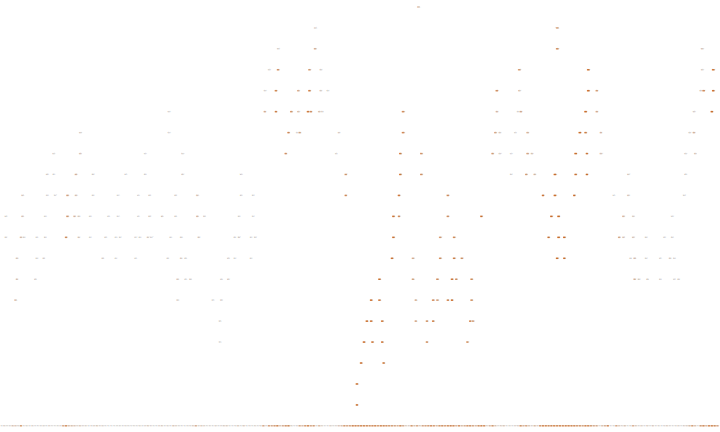

In [53]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

## Random Forest Implementation

In [60]:
def random_forest(xs, y, n_estimators=60, max_samples=10_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [61]:
m = random_forest(xs, y);

In [62]:
m_rmse(m, xs, y), m_rmse(m, valid_x, valid_y)

(0.189355, 0.229222)

In [63]:
def random_forest_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

In [65]:
fi = random_forest_feat_importance(m, xs)
fi[:10]

,cols,imp
20,col_5,0.225295
83,col_83,0.169262
106,col_106,0.084670
18,col_3,0.054207
111,col_111,0.053241
16,col_1,0.041034
56,col_54,0.039243
69,col_67,0.030755
74,col_74,0.024404
102,col_102,0.022443


### Filter Features

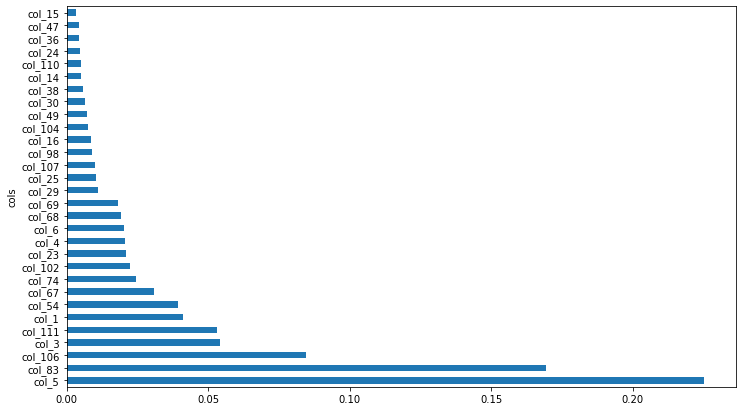

In [66]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

Filter important features with importance > 0.005

In [94]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

26

In [80]:
# Filter training set & validation set with to_keep features only
x_imp = xs[to_keep]
valid_x_imp = valid_x[to_keep]

In [81]:
m = random_forest(x_imp, y)

Note that the RMSE value after filtering important features does not increase by much

In [82]:
m_rmse(m, x_imp, y), m_rmse(m, valid_x_imp, valid_y)

(0.192347, 0.229995)

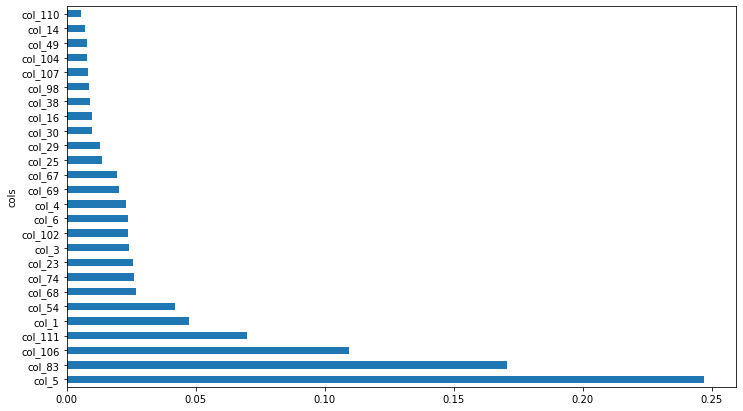

In [76]:
plot_fi(random_forest_feat_importance(m, x_imp));

This time, let's try dropping similar features. We can filter the features by checking which features are merged early in the process.

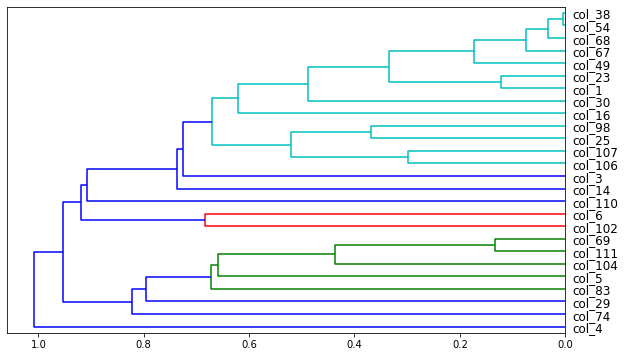

In [77]:
cluster_columns(x_imp)

Use OOB score to determine impact of removing features

In [84]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=5000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [95]:
#Baseline
get_oob(x_imp)

0.6935610672902517

In [86]:
#Try dropping features one by one
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'col_38', 'col_54')}

{'col_38': 0.6912450172095381, 'col_54': 0.6910411924618524}

In [87]:
#Drop one feature
to_drop = ['col_38']
get_oob(xs_imp.drop(to_drop, axis=1))

0.692672423916527

There is no big difference between using to_drop feature and not. So, it is safe to drop the feature

In [89]:
x_final = xs_imp.drop(to_drop, axis=1)
valid_x_final = valid_x_imp.drop(to_drop, axis=1)

Get RMSE again after dropping similar category

In [91]:
m = random_forest(x_final, y)
m_rmse(m, x_final, y), m_rmse(m, valid_x_final, valid_y)

(0.192831, 0.230403)

In [97]:
#Save data using Python pickle
save_pickle(path/'x_final.pkl', x_final)
save_pickle(path/'valid_x_final.pkl', valid_x_final)